## The Basics

We're going to walk through the basics of the `dtk-tools` functionality:

- configuring a simulation
- running a simulation on your local machine
- monitoring the progress of a submitted simulation
- plotting from the simulation output files

### Configuring a simulation

Let's start by defining a default `DTKConfigBuilder` object.  This holds the configuration parameters, campaign events, and a few other details that are beyond the present scope.

We'll also use the demographics and climate for a single-village set-up based on Namawala, Tanzania.

And finally, let's modify the duration of the simulation to be five years.

In [1]:
from dtk.utils.core.DTKConfigBuilder import DTKConfigBuilder
from dtk.vector.study_sites import configure_site

cb = DTKConfigBuilder.from_defaults('VECTOR_SIM')
configure_site(cb, 'Namawala')
cb.set_param('Simulation_Duration', 5*365)

run_sim_args =  { 'config_builder' : cb,
                  'exp_name'       : 'VectorDemo' }

### Running a simulation

If we were running from the command line, we might save the code above in a file, e.g. `demo.py`, and then call: 
```
dtk run demo.py
```

More command-line flags are listed on the corresponding help pages:
```
dtk run -h
```

But for now, we'll just define a `SimulationManager` and call into the same functionality with the `run_demo()` function defined below.

In [2]:
from dtk.utils.core.DTKSetupParser import DTKSetupParser
from dtk.utils.simulation.SimulationManager import SimulationManagerFactory

sm = SimulationManagerFactory.from_exe(DTKSetupParser().get('BINARIES','exe_path'),'LOCAL')

def run_demo():
    sm.RunSimulations(**run_sim_args)

Let's run the simulation now, and print out the meta-data associated with the `SimulationManager` that should also be cached locally as a JSON file in the `simulations` sub-directory.

In [3]:
run_demo()

from IPython.display import display
display(sm.exp_data)

{'exp_id': '2016_01_06_14_14_36_049000',
 'exp_name': 'VectorDemo',
 'location': 'LOCAL',
 'sim_root': 'E:\\EMOD\\simulations_local\\',
 'sim_type': 'VECTOR_SIM',
 'sims': {'2016_01_06_14_14_36_061000': {'jobId': 4028}}}

###Monitoring simulation status

Monitoring the status of simulations from the command line can be done as follows:
```
dtk status
```

By default, this would take the most recent cached simulation meta-data and reconstruct the `SimulationManager` object.  We'll just keep the manager we have and use the `monitor_status()` function defined below.

In [4]:
import time

def monitor_status():
    while True:
        states, msgs = sm.SimulationStatus()
        if sm.statusFinished(states): 
            break
        else:
            sm.printStatus(states, msgs)
            time.sleep(3)
    sm.printStatus(states, msgs)

In [5]:
monitor_status()

Job states:
{
    "4028": "Finished"
}
{'Finished': 1}


### Plotting the simulation output

Let's define a list of two analyzers we want to apply to the output of this simulation, one looking at the time series in the `InsetChart.json` output file and the other looking at per-species channels in `VectorSpeciesReport.json`.

The analyzer objects can be passed logic on how they should filter, select, group, and plot channels from these input files.

In [6]:
from dtk.utils.analyzers import sample_selection, group_by_name, plot_grouped_lines, \
                                TimeseriesAnalyzer, VectorSpeciesAnalyzer

analyzers = [ TimeseriesAnalyzer(
                filename='InsetChart.json',
                channels=['Rainfall', 'Adult Vectors', 'Daily EIR', 'Infected'],
                select_function=sample_selection(freq='W', start_date='1/1/2000'),
                group_function=group_by_name('_site_'),
                plot_function=plot_grouped_lines
                ),
              VectorSpeciesAnalyzer(
                filename='VectorSpeciesReport.json',
                channels=['Adult Vectors', 'Daily EIR'],        
                select_function=sample_selection(freq='W', start_date='1/1/2000'),
                group_function=group_by_name('_site_'),
                )
            ]

If we were running from the command line, we might save the code above in a file, e.g. `plots.py`, and then call: 
```
dtk analyze plots.py
```

We'll add these analyzers to our existing `SimulationManager` and call the `draw_plots()` function defined below.

In [7]:
def draw_plots():
    sm.analyzers = analyzers
    sm.AnalyzeSimulations()

(0, '2016_01_06_14_14_36_061000')


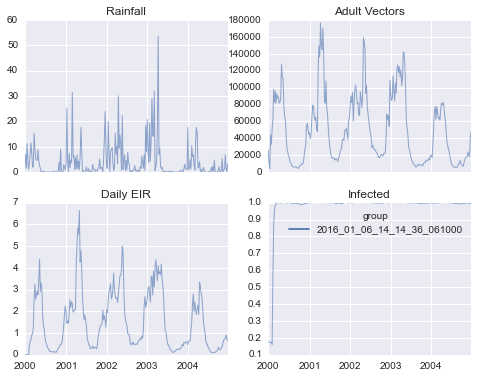

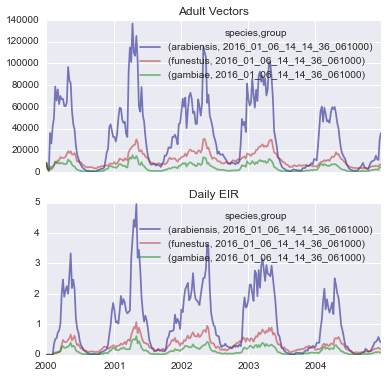

In [8]:
%matplotlib inline 
draw_plots()